In [134]:
import pandas as pd
import numpy as np
import os
from scipy.cluster.vq import whiten
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import linkage,fcluster
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.vq import kmeans, vq
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
import nltk
from collections import Counter
import string
import seaborn as sns
%matplotlib inline
import datetime as dt
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,recall_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [135]:
sheet_to_df_map = pd.read_excel('online_retail_II.xlsx', sheet_name=None)
online_retailer = pd.concat(sheet_to_df_map, axis=0, ignore_index=True)

In [136]:
online_retailer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


In [137]:
online_retailer.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [138]:
online_retailer.describe()

,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


In [139]:
#Understanding and cleaning data
#1. rows with less than 0 quantity, are cancelled orders
online_retailer[online_retailer['Quantity']<0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
...,...,...,...,...,...,...,...,...
1065910,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
1067002,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
1067176,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
1067177,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


In [140]:
# rows with negative price are bad debt adjustments
online_retailer[online_retailer['Price']<0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom
825444,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
825445,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


In [141]:
#2. remove rows without Customer ID
online_retailer_1=online_retailer.dropna(subset=['Customer ID'])

In [142]:
online_retailer_1.describe()

,Quantity,Price,Customer ID
count,824364.000000,824364.000000,824364.000000
mean,12.414574,3.676800,15324.638504
std,188.976099,70.241388,1697.464450
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13975.000000
50%,5.000000,1.950000,15255.000000
75%,12.000000,3.750000,16797.000000
max,80995.000000,38970.000000,18287.000000


In [143]:
online_retailer_1['Amount']=online_retailer_1['Price'] * online_retailer_1['Quantity']

<ipython-input-143-dfd2739f776c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  online_retailer_1['Amount']=online_retailer_1['Price'] * online_retailer_1['Quantity']


In [144]:
online_retailer_1.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Amount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [145]:
#Invoice Date splitting
online_retailer_1[["InvYear","InvMonth","InvDay"]]=online_retailer_1["InvoiceDate"].astype(str).str.split("-", expand = True)
online_retailer_1[["InvDay","InvTime"]]=online_retailer_1["InvDay"].astype(str).str.split(" ", expand = True)

C:\Users\rayanoothalav\Anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [146]:
online_retailer_1.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Amount,InvYear,InvMonth,InvDay,InvTime
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,2009,12,01,07:45:00
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009,12,01,07:45:00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009,12,01,07:45:00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,2009,12,01,07:45:00
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,2009,12,01,07:45:00


In [147]:
# Amount spent by each customer
customer_spending=pd.DataFrame(online_retailer_1.groupby('Customer ID')['Amount'].sum())
customer_spending=customer_spending.rename(columns={'Amount': 'Spending'})
customer_spending=customer_spending.reset_index()
customer_spending.head()

,Customer ID,Spending
0,12346.0,-64.68
1,12347.0,5633.32
2,12348.0,2019.40
3,12349.0,4404.54
4,12350.0,334.40


In [148]:
customer_spending.describe()

,Customer ID,Spending
count,5942.000000,5942.000000
mean,15316.500000,2801.799459
std,1715.451981,13973.922553
min,12346.000000,-25111.090000
25%,13831.250000,325.097500
50%,15316.500000,843.970000
75%,16801.750000,2182.005000
max,18287.000000,598215.220000


In [149]:
customer_spending.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5942 entries, 0 to 5941
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Customer ID  5942 non-null   float64
 1   Spending     5942 non-null   float64
dtypes: float64(2)
memory usage: 93.0 KB


In [150]:
#5942 customers have spent on average apprx. 2801.80

In [151]:
No_of_times=pd.DataFrame(online_retailer_1.groupby('Customer ID')['InvoiceDate'].nunique())
No_of_times = No_of_times.rename(columns={'InvoiceDate': 'Purchase_Frequency'})
No_of_times = No_of_times.reset_index()
No_of_times.head()

,Customer ID,Purchase_Frequency
0,12346.0,17
1,12347.0,8
2,12348.0,5
3,12349.0,5
4,12350.0,1


In [152]:
No_of_times.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5942 entries, 0 to 5941
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer ID         5942 non-null   float64
 1   Purchase_Frequency  5942 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 93.0 KB


In [153]:
No_of_times.describe()

,Customer ID,Purchase_Frequency
count,5942.000000,5942.000000
mean,15316.500000,7.511612
std,1715.451981,15.836676
min,12346.000000,1.000000
25%,13831.250000,2.000000
50%,15316.500000,4.000000
75%,16801.750000,8.000000
max,18287.000000,508.000000


In [154]:
#Each customers has purchased on average apprx. 7.5 times in 2 years, minimum 1 and maximum 508 times

In [155]:
segment_1=pd.merge(customer_spending, No_of_times)

In [156]:
segment_1['Spend_per_Inv']=segment_1['Spending']/segment_1['Purchase_Frequency']
segment_1.head()

,Customer ID,Spending,Purchase_Frequency,Spend_per_Inv
0,12346.0,-64.68,17,-3.804706
1,12347.0,5633.32,8,704.165000
2,12348.0,2019.40,5,403.880000
3,12349.0,4404.54,5,880.908000
4,12350.0,334.40,1,334.400000


In [157]:
segment_1.describe()

,Customer ID,Spending,Purchase_Frequency,Spend_per_Inv
count,5942.000000,5942.000000,5942.000000,5942.000000
mean,15316.500000,2801.799459,7.511612,293.967005
std,1715.451981,13973.922553,15.836676,522.891490
min,12346.000000,-25111.090000,1.000000,-25111.090000
25%,13831.250000,325.097500,2.000000,151.050000
50%,15316.500000,843.970000,4.000000,231.915000
75%,16801.750000,2182.005000,8.000000,357.414135
max,18287.000000,598215.220000,508.000000,11880.840000


In [158]:
#293.97 is spend by Each customer on Each purchases on average, 75% of customer purchases are within 357.41 

In [159]:
# Amount spent by Country
spending_by_country=pd.DataFrame(online_retailer_1.groupby('Country')['Amount'].sum())
spending_by_country=spending_by_country.rename(columns={'Amount': 'Revenue'})
spending_by_country=spending_by_country.sort_values('Revenue',ascending=False)
spending_by_country.head(10)

,Revenue
Country,
United Kingdom,1.380642e+07
EIRE,5.785016e+05
Netherlands,5.485250e+05
Germany,4.179886e+05
France,3.265047e+05
Australia,1.671291e+05
Switzerland,9.908281e+04
Spain,9.185948e+04
Sweden,8.745542e+04


<AxesSubplot:ylabel='Country'>

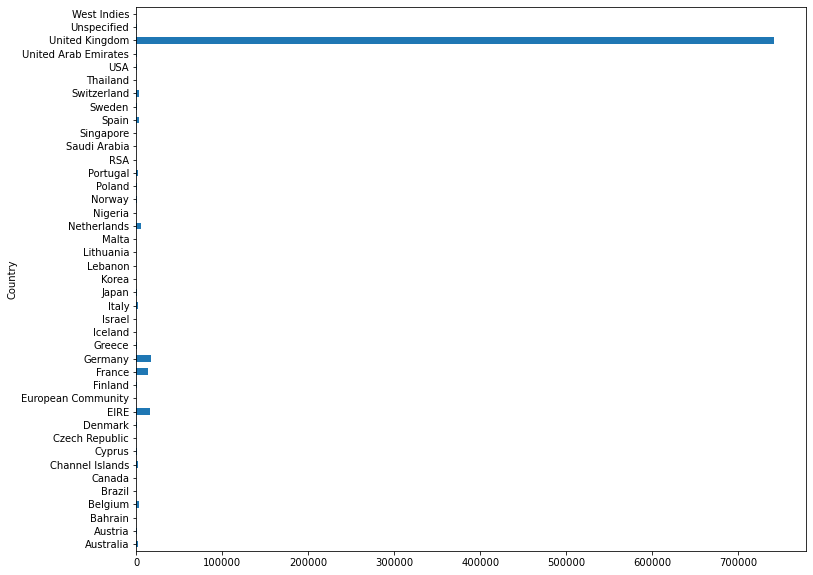

In [160]:
# Customers from each country
plt.figure(figsize=(12,10))
online_retailer_1.groupby('Country').count()['Customer ID'].plot.barh()

In [161]:
# most number of customers are from UK. however, more revenue is generated from UK

In [162]:
# Amount spent by month
monthly_spending=pd.DataFrame(online_retailer_1.groupby('InvMonth')['Amount'].sum())
monthly_spending=monthly_spending.rename(columns={'Amount': 'Monthly Spending'})
monthly_spending=monthly_spending.reset_index()
monthly_spending.head(12)

,InvMonth,Monthly Spending
0,01,1007027.282
1,02,925945.736
2,03,1215961.091
3,04,986682.873
4,05,1208175.630
5,06,1179473.070
6,07,1137024.381
7,08,1203624.460
8,09,1712473.673
9,10,1939593.370


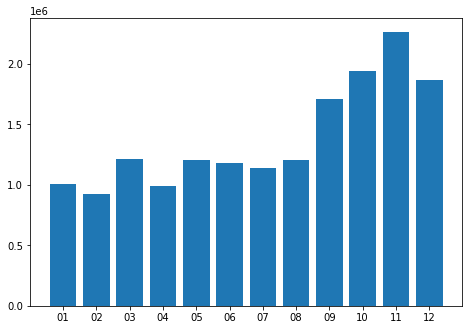

In [69]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(monthly_spending['InvMonth'],monthly_spending['Monthly Spending'])
plt.show()

<AxesSubplot:xlabel='InvMonth', ylabel='Customer ID'>

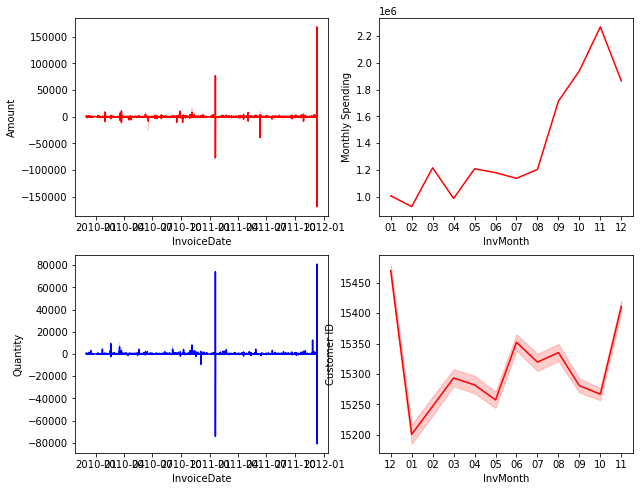

In [41]:
# create the time series subplots
fig,ax =  plt.subplots( 2, 2,
                       figsize = ( 10, 8))
  
sns.lineplot( x = "InvoiceDate", y = "Amount", 
             color = 'r', data = online_retailer_1, 
             ax = ax[0][0])
sns.lineplot( x = "InvoiceDate", y = "Quantity", 
             color = 'b', data = online_retailer_1, 
             ax = ax[1][0])
sns.lineplot( x = "InvMonth", y = "Monthly Spending", 
             color = 'r', data = monthly_spending, 
             ax = ax[0][1])
sns.lineplot( x = "InvMonth", y = "Customer ID", 
             color = 'r', data = online_retailer_1, 
             ax = ax[1][1])

<AxesSubplot:>

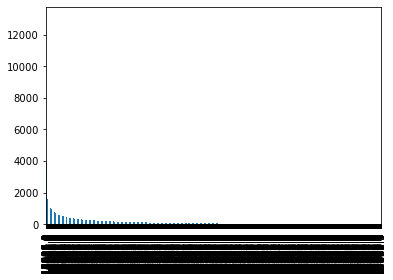

In [113]:
online_retailer_1['Customer ID'].value_counts().plot(kind='bar')

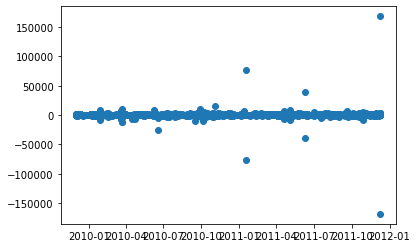

In [36]:
plt.scatter(online_retailer_1['InvoiceDate'], online_retailer_1['Amount'])
plt.show()

In [ ]:
# looks like 3 types of customer segments based on Amount and InvoiceDate scatter plot; customers bringing +revenue, -revenue, and minimal revenue

In [163]:
#Baseline clustering model

# for using pipeline, converting to int, str datatypes
online_retailer_1['InvoiceDate']=pd.to_datetime(online_retailer_1['InvoiceDate'])
online_retailer_1['InvoiceDate']=online_retailer_1['InvoiceDate'].values.astype(int)
online_retailer_1['Customer ID']=online_retailer_1['Customer ID'].values.astype(str)
online_retailer_1['Quantity']=online_retailer_1['Quantity'].values.astype(int)
online_retailer_1['Price']=online_retailer_1['Price'].values.astype(int)
online_retailer_1['Amount']=online_retailer_1['Amount'].values.astype(int)


<ipython-input-163-64260c21582c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  online_retailer_1['InvoiceDate']=pd.to_datetime(online_retailer_1['InvoiceDate'])
<ipython-input-163-64260c21582c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  online_retailer_1['InvoiceDate']=online_retailer_1['InvoiceDate'].values.astype(int)
<ipython-input-163-64260c21582c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [173]:
#4. remove rows without Customer ID
online_retailer_2=online_retailer.dropna(subset=['Customer ID'])
online_retailer_2['Amount']=online_retailer_2['Price'] * online_retailer_2['Quantity']

<ipython-input-173-7f3e17b98e17>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  online_retailer_2['Amount']=online_retailer_2['Price'] * online_retailer_2['Quantity']


In [178]:
online_retailer_2['InvoiceDate']=pd.to_datetime(online_retailer_2['InvoiceDate'])
online_retailer_2['InvoiceDate']=online_retailer_2['InvoiceDate'].values.astype(str)
online_retailer_2['Invoice']=online_retailer_2['Invoice'].values.astype(str)
online_retailer_2['StockCode']=online_retailer_2['StockCode'].values.astype(str)
online_retailer_2['Description']=online_retailer_2['Description'].values.astype(str)
online_retailer_2['Price']=online_retailer_2['Price'].values.astype(int)
online_retailer_2['Amount']=online_retailer_2['Amount'].values.astype(int)
online_retailer_2['Customer ID']=online_retailer_2['Customer ID'].values.astype(str)
online_retailer_2['Country']=online_retailer_2['Country'].values.astype(str)
print(online_retailer_2.dtypes)

<ipython-input-178-21187e65824d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  online_retailer_2['InvoiceDate']=pd.to_datetime(online_retailer_2['InvoiceDate'])
<ipython-input-178-21187e65824d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  online_retailer_2['InvoiceDate']=online_retailer_2['InvoiceDate'].values.astype(str)
<ipython-input-178-21187e65824d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

Invoice        object
StockCode      object
Description    object
Quantity        int64
InvoiceDate    object
Price           int32
Customer ID    object
Country        object
Amount          int32
dtype: object


<ipython-input-178-21187e65824d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  online_retailer_2['Country']=online_retailer_2['Country'].values.astype(str)


In [179]:
#pipeline format to get kmeans clusters

numerical_cols =['Quantity','Amount','Price']
categorical_cols = ['Invoice','StockCode','Description','Country','InvoiceDate','Customer ID']

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
numerical_pipe = Pipeline([("imputer", SimpleImputer(strategy="mean")),("scaler", StandardScaler())])

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_cols),
        ("num", numerical_pipe, numerical_cols),
    ]
)

pipe_kmeans = Pipeline(
    steps=[("preprocess", preprocessing), ("kmeans", KMeans(n_clusters=3,random_state=0))]
)
pipe_kmeans.fit(online_retailer_2)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Invoice', 'StockCode',
                                                   'Description', 'Country',
                                                   'InvoiceDate',
                                                   'Customer ID']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Quantity', 'Amount',
                                                   'Price'])])),
             

In [180]:
pipe_kmeans.named_steps

{'preprocess': ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'),
                                  ['Invoice', 'StockCode', 'Description',
                                   'Country', 'InvoiceDate', 'Customer ID']),
                                 ('num',
                                  Pipeline(steps=[('imputer', SimpleImputer()),
                                                  ('scaler', StandardScaler())]),
                                  ['Quantity', 'Amount', 'Price'])]),
 'kmeans': KMeans(n_clusters=3, random_state=0)}

In [181]:
# Feature names after processing
ohe = pipe_kmeans.named_steps["preprocess"].named_transformers_["cat"]
feature_names = ohe.get_feature_names(categorical_cols)
kmeans_cols = np.r_[feature_names,numerical_cols]

In [182]:
pipe_kmeans['kmeans'].cluster_centers_

array([[ 9.70474526e-06,  4.85237263e-06,  2.30487700e-05, ...,
         2.05009495e-06,  4.61692940e-04, -3.83142998e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.57773861e+01, -5.11418809e+01,  1.37323573e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.10594953e+02,  3.97835882e+02, -2.25049789e-02]])

In [184]:
pd.DataFrame(pipe_kmeans['kmeans'].cluster_centers_,columns=kmeans_cols)

,Invoice_489434,Invoice_489435,Invoice_489436,Invoice_489437,Invoice_489438,Invoice_489439,Invoice_489440,Invoice_489441,Invoice_489442,Invoice_489443,...,Customer ID_18281.0,Customer ID_18282.0,Customer ID_18283.0,Customer ID_18284.0,Customer ID_18285.0,Customer ID_18286.0,Customer ID_18287.0,Quantity,Amount,Price
0,0.00001,0.000005,0.000023,0.000028,0.000021,0.000023,0.000002,0.000005,0.000028,0.000008,...,0.000021,0.000016,0.001196,0.000035,0.000015,0.000085,0.000189,0.000002,0.000462,-0.003831
1,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-35.777386,-51.141881,137.323573
2,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,410.594953,397.835882,-0.022505


In [185]:
## Reviewing cluster composition
online_retailer_2['clusters'] = pipe_kmeans.predict(online_retailer_2)

<ipython-input-185-5cd2216eca1e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  online_retailer_2['clusters'] = pipe_kmeans.predict(online_retailer_2)


In [186]:
online_retailer_2['clusters'].value_counts()

0    824339
1        23
2         2
Name: clusters, dtype: int64

In [187]:
online_retailer_2.groupby('clusters')[numerical_cols].mean()

,Quantity,Amount,Price
clusters,,,
0,12.414962,19.869580,2.811637
1,-6748.652174,-15767.043478,9648.739130
2,77605.000000,122826.000000,1.500000


In [ ]:
fig, ax = plt.subplots(6,1,figsize=(12,12))
for i,col in enumerate(categorical_cols):
    hmm = online_retailer_2.groupby('clusters')[col].value_counts(normalize=True).rename('fraction').reset_index()
    sns.barplot(x="clusters", y="fraction",hue=col, data=hmm,ax=ax[i])
    
plt.tight_layout()

<ipython-input-189-2b631a8b71bb>:6: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()
